<a href="https://colab.research.google.com/github/rpatwardhan7/Recorrupted-to-Recorrupted-Image-Denoising/blob/main/PolyU_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DnCNN Denoising Experiment on PolyU

In [ ]:
!git clone https://github.com/cszn/DnCNN.git

Cloning into 'DnCNN'...
remote: Enumerating objects: 946, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 946 (delta 6), reused 0 (delta 0), pack-reused 934
Receiving objects: 100% (946/946), 127.72 MiB | 33.03 MiB/s, done.
Resolving deltas: 100% (184/184), done.


In [ ]:
!git clone https://github.com/csjunxu/PolyU-Real-World-Noisy-Images-Dataset.git

Cloning into 'PolyU-Real-World-Noisy-Images-Dataset'...
remote: Enumerating objects: 419, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 419 (delta 0), reused 0 (delta 0), pack-reused 416
Receiving objects: 100% (419/419), 138.11 MiB | 33.27 MiB/s, done.
Resolving deltas: 100% (84/84), done.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
import os
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.autograd import Variable
from torch.utils.data import DataLoader

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Collect data

In [ ]:
cropped_path = '/content/PolyU-Real-World-Noisy-Images-Dataset/CroppedImages'
cropped_img_list = os.listdir(cropped_path)

N = len(cropped_img_list) #number of noisy and ground truth
H, W = 512, 512
Cropped_tensor = torch.zeros(int(N / 2), H, W, 3) #real_JPG are noisy
Ground_truth = torch.zeros(int(N / 2), H, W, 3) #mean.JPG are clean

for i, img_name in enumerate(sorted(cropped_img_list)):
    img_path = cropped_path + '/' + img_name
    img = cv2.imread(img_path) / 255.0

    if img_path.endswith('real.JPG'): #this is a noisy image
      Cropped_tensor[int(i/2)] = torch.from_numpy(img)
    elif img_path.endswith('mean.JPG'): #this is a clean image
      Ground_truth[int(i/2)] = torch.from_numpy(img)

200
torch.Size([100, 512, 512, 3])
torch.Size([100, 512, 512, 3])


## Recorruption 
In this section, we construct the training dataset composed of $\hat{y}$ and $\tilde{y}$. These values are computed from the y tensor.

In [ ]:
import numpy as np
from cv2 import imread
from skimage import img_as_float
import time

def im2patch(im, pch_size, stride=1):
    '''
    Transform image to patches.
    Input:
        im: 3 x H x W or 1 X H x W image, numpy format
        pch_size: (int, int) tuple or integer
        stride: (int, int) tuple or integer
    '''
    if isinstance(pch_size, tuple):
        pch_H, pch_W = pch_size
    elif isinstance(pch_size, int):
        pch_H = pch_W = pch_size
    else:
        sys.exit('The input of pch_size must be a integer or a int tuple!')

    if isinstance(stride, tuple):
        stride_H, stride_W = stride
    elif isinstance(stride, int):
        stride_H = stride_W = stride
    else:
        sys.exit('The input of stride must be a integer or a int tuple!')


    C, H, W = im.shape
    num_H = len(range(0, H-pch_H+1, stride_H))
    num_W = len(range(0, W-pch_W+1, stride_W))
    num_pch = num_H * num_W
    pch = np.zeros((C, pch_H*pch_W, num_pch), dtype=float)
    kk = 0
    for ii in range(pch_H):
        for jj in range(pch_W):
            temp = im[:, ii:H-pch_H+ii+1:stride_H, jj:W-pch_W+jj+1:stride_W]
            pch[:, kk, :] = temp.reshape((C, num_pch))
            kk += 1

    return pch.reshape((C, pch_H, pch_W, num_pch))

In [ ]:
def noise_estimate(im, pch_size=8):
    '''
    Implement of noise level estimation of the following paper:
    Chen G , Zhu F , Heng P A . An Efficient Statistical Method for Image Noise Level Estimation[C]// 2015 IEEE International Conference
    on Computer Vision (ICCV). IEEE Computer Society, 2015.
    Input:
        im: the noise image, H x W x 3 or H x W numpy tensor, range [0,1]
        pch_size: patch_size
    Output:
        noise_level: the estimated noise level
    '''

    if im.ndim == 3:
        im = torch.permute(im, (2, 0, 1))
    else:
        im = np.expand_dims(im, axis=0)

    # image to patch
    pch = im2patch(im, pch_size, 3)  # C x pch_size x pch_size x num_pch tensor
    num_pch = pch.shape[3]
    pch = pch.reshape((-1, num_pch))  # d x num_pch matrix
    d = pch.shape[0]

    mu = pch.mean(axis=1, keepdims=True)  # d x 1
    X = pch - mu
    sigma_X = np.matmul(X, X.transpose()) / num_pch
    sig_value, _ = np.linalg.eigh(sigma_X)
    sig_value.sort()

    for ii in range(-1, -d-1, -1):
        tau = np.mean(sig_value[:ii])
        if np.sum(sig_value[:ii]>tau) == np.sum(sig_value[:ii] < tau):
            return np.sqrt(tau)

In [ ]:
from scipy.linalg import sqrtm

class R2RDenoisingDataset(Dataset):
    def __init__(self, y_tensor, alpha = 0.75):
        '''
        Inputs: 
        - y_tensor: tensor of cropped images (shape N x H x W x 3)
        - alpha: parameter of recorruption used in paper (default 0.75)
        '''
        super(R2RDenoisingDataset, self).__init__()
        self.y_tensor = y_tensor
        self.Y1 = torch.zeros(int(N/2), 3, H, W)
        self.Y2 = torch.zeros(int(N/2), 3, H, W)
        for i in range(len(self.y_tensor)):
            z = torch.randn(H, W).double()
            image = Cropped_tensor[i]
            A = image
            B = image
            sigma = noise_estimate(image, pch_size=32)
            for c in range(3):
              A[:, :, c] = A[:, :, c] + torch.matmul(torch.from_numpy(20 * sigma * np.identity(512)), z)
              B[:, :, c] = B[:, :, c] - torch.matmul(torch.from_numpy(sigma * np.identity(512) / 20), z)
            self.Y1[i] = A.permute(2, 0, 1) #y hat
            self.Y2[i] = B.permute(2, 0, 1) #y tilde

    def __len__(self):
        return len(self.y_tensor)

    def __getitem__(self, idx):
        return self.Y1[idx], self.Y2[idx]

In [ ]:
ds = R2RDenoisingDataset(Cropped_tensor)
print(len(ds))

100


In [ ]:
import pickle
with open('PolyU_patch_size_32.pkl', 'wb') as file_id:
     pickle.dump(ds, file_id)

### Construct Train and Test Datasets

In [ ]:
train_size = int(0.7 * (N / 2))
print(train_size)
test_size = len(ds) - train_size
print(test_size)
train_dataset, test_dataset = torch.utils.data.random_split(ds, [train_size, test_size])

70
30


## DnCNN model for denoising

In [ ]:
import torch.nn.init as init
from torch.optim.lr_scheduler import MultiStepLR

In [ ]:
class R2RDenoisingModel(nn.Module):
    def __init__(self, depth=17, n_channels=64, image_channels=3, use_bnorm=True, kernel_size=3):
        super(R2RDenoisingModel, self).__init__()
        kernel_size = 3
        padding = 1
        layers = []

        layers.append(nn.Conv2d(in_channels=image_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=True))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(depth-2):
            layers.append(nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(n_channels, eps=0.0001, momentum = 0.95))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=n_channels, out_channels=image_channels, kernel_size=kernel_size, padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)
        self._initialize_weights()

    def forward(self, x):
        y = x
        out = self.dncnn(x)
        return y-out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.orthogonal_(m.weight)
                print('init weight')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)

## Model Training

DnCNN hyper-parameters
- 180 epochs
- lr (init 1e-3) descent at 30, 60, and 90 epochs (gamma = 0.2)
- batch size 128

In [ ]:
num_epochs = 30
batch_size = 4
model = R2RDenoisingModel(depth=17).to(device)
criterion = nn.MSELoss(reduction = 'sum')
init_learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), init_learning_rate)
lr_control = MultiStepLR(optimizer, milestones=[30, 60, 90], gamma=0.2)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight


NameError: ignored

In [ ]:
torch.cuda.empty_cache()

In [ ]:
train_mse = torch.zeros(num_epochs)
test_mse = torch.zeros(num_epochs)
for epoch in range(num_epochs):
    avg_train_mse = 0.0
    for idx, (y1_batch, y2_batch) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        model_input = Variable(y1_batch.to(device))
        expected_out = Variable(y2_batch.to(device))
        out = model(model_input)
        loss = criterion(out, expected_out)
        loss.backward()
        optimizer.step()

        batch_mse = criterion(out, expected_out)
        avg_train_mse += batch_mse.item() / batch_size
    avg_train_mse /= len(train_loader)
    train_mse[epoch] = avg_train_mse
    print("Epoch: ", str(epoch), '\t', 'Avg Train MSE: ', str(avg_train_mse))

KeyboardInterrupt: ignored

In [ ]:
torch.save(model.state_dict(), 'checkpoint.pth')

# download checkpoint file
files.download('checkpoint.pth')

In [ ]:
#load checkpoint file
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()

state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

odict_keys(['dncnn.0.weight', 'dncnn.0.bias', 'dncnn.2.weight', 'dncnn.3.weight', 'dncnn.3.bias', 'dncnn.3.running_mean', 'dncnn.3.running_var', 'dncnn.3.num_batches_tracked', 'dncnn.5.weight', 'dncnn.6.weight', 'dncnn.6.bias', 'dncnn.6.running_mean', 'dncnn.6.running_var', 'dncnn.6.num_batches_tracked', 'dncnn.8.weight', 'dncnn.9.weight', 'dncnn.9.bias', 'dncnn.9.running_mean', 'dncnn.9.running_var', 'dncnn.9.num_batches_tracked', 'dncnn.11.weight', 'dncnn.12.weight', 'dncnn.12.bias', 'dncnn.12.running_mean', 'dncnn.12.running_var', 'dncnn.12.num_batches_tracked', 'dncnn.14.weight', 'dncnn.15.weight', 'dncnn.15.bias', 'dncnn.15.running_mean', 'dncnn.15.running_var', 'dncnn.15.num_batches_tracked', 'dncnn.17.weight', 'dncnn.18.weight', 'dncnn.18.bias', 'dncnn.18.running_mean', 'dncnn.18.running_var', 'dncnn.18.num_batches_tracked', 'dncnn.20.weight', 'dncnn.21.weight', 'dncnn.21.bias', 'dncnn.21.running_mean', 'dncnn.21.running_var', 'dncnn.21.num_batches_tracked', 'dncnn.23.weight', '

In [ ]:
epochs = range(30)
plt.plot(epochs, train_mse, 'g', label='Training loss')
plt.title('Training Curve for the PolyU Dataset')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

#Test Model Performance

####Test Model performance on the test dataset given the trained model

In [ ]:
torch.cuda.empty_cache()

In [ ]:
test_loader = DataLoader(test_dataset, shuffle=True)
avg_test_loss = 0
model.eval()
for idx, (y1, y2) in enumerate(test_loader):
    model_input = y1.to(device)
    expected_out = y2.to(device)
    out = model(model_input)
    loss = criterion(out, expected_out)
    print('Loss: ', str(loss))
    avg_test_loss += loss.item()

avg_test_loss /= len(test_dataset)
print('Avg Test Loss: ', str(avg_test_loss))  

# Statistics

####Ground Truth of the Cropped Images

In [ ]:
TST_IMG = 98

model_input = Cropped_tensor[TST_IMG].permute(2, 0, 1).to(device)

model_output = model(torch.unsqueeze(model_input, 0))
model_output = torch.squeeze(model_output).permute(1, 2, 0).cpu().detach()

print("NOISY")
noisy = cv2_imshow(cv2.cvtColor(Cropped_tensor[TST_IMG].numpy() * 255.0, cv2.COLOR_BGR2RGB))

print("Model Output")
img = cv2_imshow(cv2.cvtColor(model_output.numpy() * 255.0, cv2.COLOR_BGR2RGB))

print("Clean Image")
orig = cv2_imshow(cv2.cvtColor(Ground_truth[TST_IMG].numpy() * 255.0, cv2.COLOR_BGR2RGB))


In [ ]:
from skimage import metrics
import pickle

In [ ]:
psnr_scores = torch.zeros(len(Cropped_tensor))
ssim_scores = torch.zeros(len(Cropped_tensor))
pred_tensor = torch.zeros(len(Cropped_tensor), H, W, 3)
model_outputs = torch.zeros(len(Cropped_tensor), H, W, 3)
for img_num in range(len(Cropped_tensor)):
    model_input = Cropped_tensor[img_num].permute(2, 0, 1).to(device)
    model_output = model(torch.unsqueeze(model_input, 0))
    model_output = torch.squeeze(model_output).permute(1, 2, 0).cpu().detach()
    pred = torch.clamp(model_output, 0.0, 1.0)
    model_outputs[img_num] = model_output
    pred_tensor[img_num] = pred
    psnr_scores[img_num] = metrics.peak_signal_noise_ratio(Ground_truth[img_num].numpy(), pred.numpy() , data_range=1.0)
    ssim_scores[img_num] = metrics.structural_similarity(Ground_truth[img_num].numpy(), pred.numpy(), multichannel=True)

TypeError: ignored

In [ ]:
with open('PSNR_Scores.pkl', 'wb') as file_id:
     pickle.dump(psnr_scores, file_id)

with open('SSIM_Scores.pkl', 'wb') as file_id:
     pickle.dump(ssim_scores, file_id)

with open('Pred_Tensor.pkl', 'wb') as file_id:
     pickle.dump(pred_tensor, file_id)

#pickled tensors for later use

In [ ]:
#reload pickled tensors for visualization purposes

with open('PSNR_Scores.pkl', 'rb') as f:
    psnr_scores = pickle.load(f)

with open('SSIM_Scores.pkl', 'rb') as f:
    ssim_scores = pickle.load(f)

with open('Pred_Tensor.pkl', 'rb') as f:
    pred_tensor = pickle.load(f)

In [ ]:
plt.hist(psnr_scores.numpy(), density=False, bins=20)  # density=False would make counts
plt.ylabel('Count')
plt.xlabel('PSNR on PolyU')
avg_psnr = torch.mean(psnr_scores)
print("Average PSNR", avg_psnr)

In [ ]:
plt.hist(ssim_scores.numpy(), density=False, bins=20)  # density=False would make counts
plt.ylabel('Count')
plt.xlabel('SSIM on PolyU');
avg_ssim = torch.mean(ssim_scores)
print("Average SSIM", avg_ssim)

NOISY


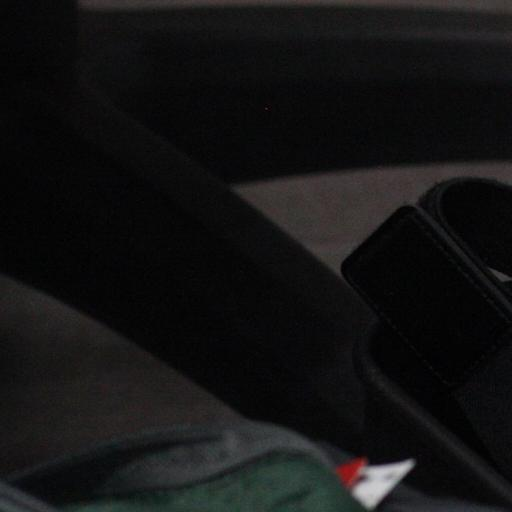

RECONSTRUCTED CLEAN IMAGE


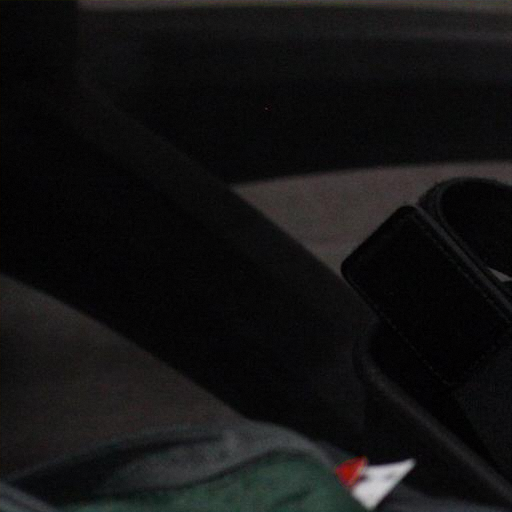

CLEAN IMAGE


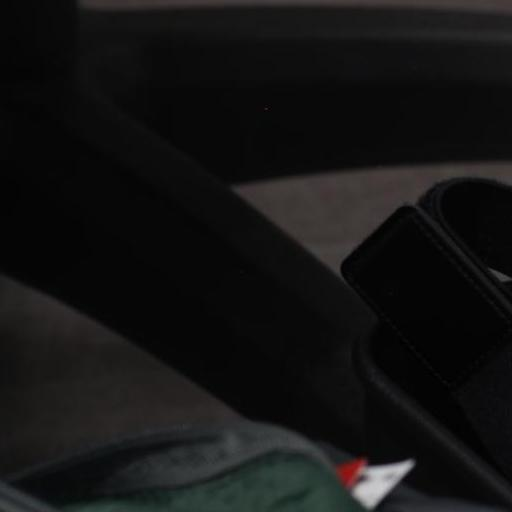

tensor(39.6065)
tensor(0.9783)


In [ ]:
best_img_num = torch.argmax(psnr_scores).item()
best_pred = pred_tensor[best_img_num].numpy()
viewable = (best_pred * 255.0).astype(int)
print("NOISY")
orig = cv2_imshow(Cropped_tensor[best_img_num].numpy() * 255.0)
print("RECONSTRUCTED CLEAN IMAGE")
img = cv2_imshow(viewable)
print("CLEAN IMAGE")
clean = cv2_imshow(Ground_truth[best_img_num].numpy() * 255.0)

print(psnr_scores[best_img_num])
print(ssim_scores[best_img_num])

NOISY


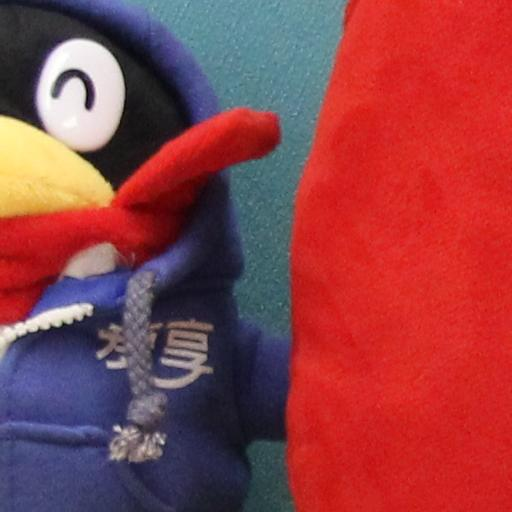

RECONSTRUCTED CLEAN IMAGE


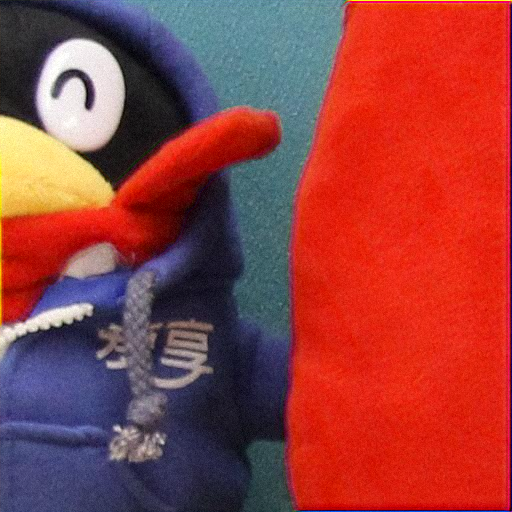

CLEAN IMAGE


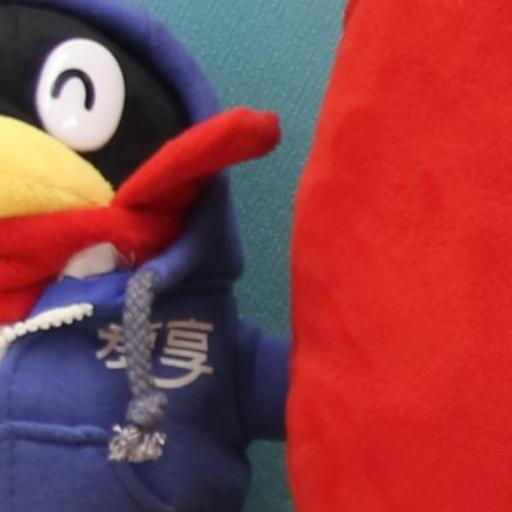

tensor(24.9596)
tensor(0.8442)


In [ ]:
worst_img_num = torch.argmin(psnr_scores).item()
worst_pred = pred_tensor[worst_img_num].numpy()
viewable = (worst_pred * 255.0).astype(int)
print("NOISY")
orig = cv2_imshow(Cropped_tensor[worst_img_num].numpy() * 255.0)
print("RECONSTRUCTED CLEAN IMAGE")
img = cv2_imshow(viewable)
print("CLEAN IMAGE")
clean = cv2_imshow(Ground_truth[worst_img_num].numpy() * 255.0)

print(psnr_scores[worst_img_num])
print(ssim_scores[worst_img_num])

NOISY


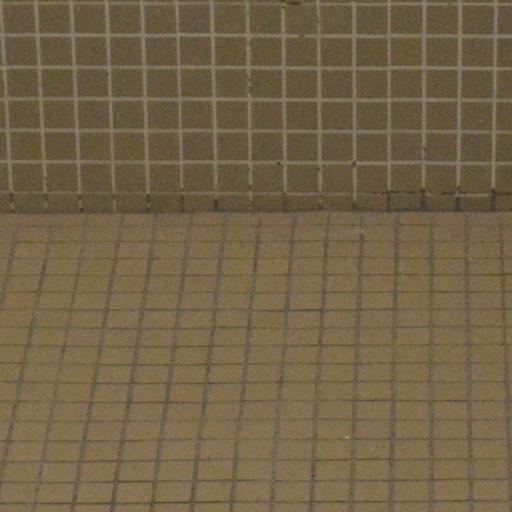

RECONSTRUCTED CLEAN IMAGE


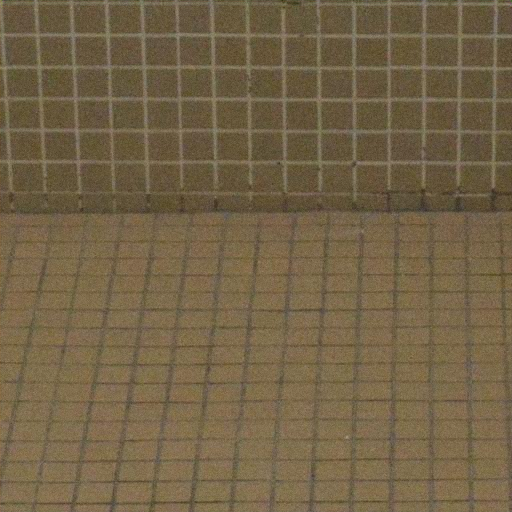

CLEAN IMAGE


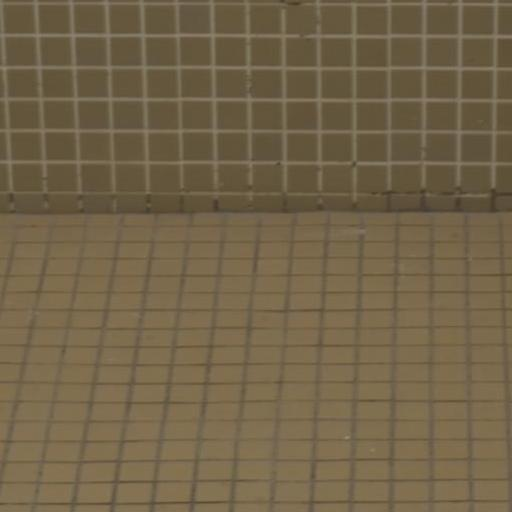

tensor(31.7274)
tensor(0.8861)


In [ ]:
median = torch.median(psnr_scores)
median_index = 0
for i in range(len(psnr_scores)):
    if psnr_scores[i] == median:
        median_index = i

med_pred = pred_tensor[median_index].numpy()
viewable = (med_pred * 255.0).astype(int)
print("NOISY")
orig = cv2_imshow(Cropped_tensor[median_index].numpy() * 255.0)
print("RECONSTRUCTED CLEAN IMAGE")
img = cv2_imshow(viewable)
print("CLEAN IMAGE")
clean = cv2_imshow(Ground_truth[median_index].numpy() * 255.0)

print(psnr_scores[median_index])
print(ssim_scores[median_index])